In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta, uniform

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

Implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with known class-conditional densities and known prevalence
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
- Platt scaling
- Isotonic regression
- Temperature scaling
4. Evaluate the calibration curves on the full base dataset: which come closest to recovering the correct prevalence estimate

## 1 Intrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    num_pos_item = int(p_pos * num_base_size)
    num_neg_item = num_base_size - num_pos_item

    scores_of_pos_items = pos_density_rv.generate_data(num_pos_item)
    scores_of_neg_items = neg_density_rv.generate_data(num_neg_item)

    items = []
    gt_label_dict = {}
    item_idx = 0

    for score in scores_of_pos_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'pos'
        item_idx += 1
    
    for score in scores_of_neg_items:
        item = Item(uid=item_idx, all_labels=['pos', 'neg'], all_probs=[score, 1-score])
        items.append(item)
        gt_label_dict[item.uid] = 'neg'
        item_idx += 1

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
pos_density_rv = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[1, 0])
neg_density_rv = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[1, 0])

p_pos = 0.1

num_base_size = 10000
num_bin = 10

In [5]:
intrinsic_base_dataset, intrinsic_gt_label_dict = generate_intrinsic_dataset(pos_density_rv, neg_density_rv, p_pos, num_base_size)

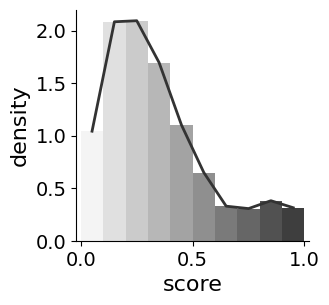

In [6]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=10)
intrinsic_base_dataset.classifier_score_distribution.plot()

In [7]:
# ground truth prevalence
Counter(intrinsic_gt_label_dict.values())["pos"] / num_base_size

0.1

### 1.2 Subsample calibration sample

In [8]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='$C(x)$', ylabel='$P(y=1|C(x))$'>],
      dtype=object)

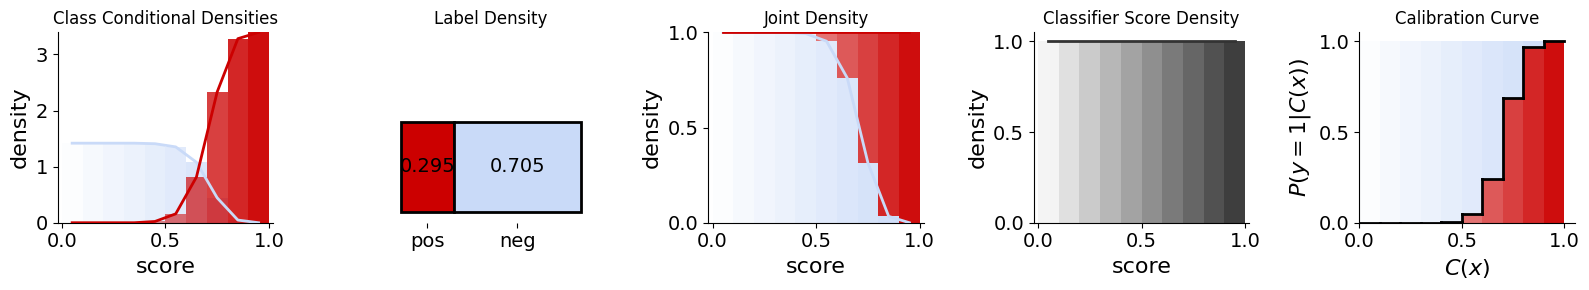

In [9]:
# 2. Select a subset of the dataset and annotate the labels
intrinsic_selected_dataset, intrinsic_selection_weights = (
    intrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    intrinsic_gt_label_dict[uid]
    for uid in intrinsic_selected_dataset.df["uid"].values.astype(int)
]
intrinsic_selected_dataset.annotate_sample(annotated_labels)

intrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [10]:
intrinsic_selected_dataset.df.head(10)

uid gt_label     p_pos     p_neg
bin                                          
0   2874  2874.0      neg  0.041910  0.958090
    1422  1422.0      neg  0.073635  0.926365
    2049  2049.0      neg  0.028883  0.971117
    3741  3741.0      neg  0.059642  0.940358
    5692  5692.0      neg  0.016655  0.983345
    4438  4438.0      neg  0.065142  0.934858
    2708  2708.0      neg  0.096247  0.903753
    4778  4778.0      neg  0.059156  0.940844
    9940  9940.0      neg  0.027944  0.972056
    1923  1923.0      neg  0.051526  0.948474

In [11]:
binning_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [12]:
intrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = intrinsic_selected_dataset.calibration_curve

# estimated_w, estimated_b = ps_calibration_curve.get_params()
# estimated_w = estimated_w.item()
# estimated_b = estimated_b.item()

# print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

Accuracy of each fold: [0.6766666666666666, 0.68, 0.71, 0.7133333333333334, 0.7466666666666667]
c=0.01, avg_acc=0.7053333333333333
Accuracy of each fold: [0.9333333333333333, 0.9233333333333333, 0.9333333333333333, 0.93, 0.92]
c=0.1, avg_acc=0.9280000000000002
Accuracy of each fold: [0.9466666666666667, 0.9366666666666666, 0.9466666666666667, 0.9366666666666666, 0.9266666666666666]
c=1, avg_acc=0.9386666666666666
Accuracy of each fold: [0.95, 0.9333333333333333, 0.9466666666666667, 0.9366666666666666, 0.9266666666666666]
c=10, avg_acc=0.9386666666666666
Accuracy of each fold: [0.95, 0.9333333333333333, 0.9466666666666667, 0.9366666666666666, 0.9266666666666666]
c=100, avg_acc=0.9386666666666666
best_c=1, best_avg_acc=0.9386666666666666


In [13]:
intrinsic_selected_dataset.update_calibration_curve(method="temperature scaling")
temperature_calibration_curve = intrinsic_selected_dataset.calibration_curve

[[0.04190987 0.95809013]
 [0.07363499 0.92636501]
 [0.02888284 0.97111716]
 [0.05964154 0.94035846]
 [0.01665533 0.98334467]
 [0.06514216 0.93485784]
 [0.09624712 0.90375288]
 [0.05915558 0.94084442]
 [0.02794409 0.97205591]
 [0.05152569 0.94847431]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7136711777017601
[[0.04190987 0.95809013]
 [0.02888284 0.97111716]
 [0.05964154 0.94035846]
 [0.06514216 0.93485784]
 [0.09624712 0.90375288]
 [0.02794409 0.97205591]
 [0.05152569 0.94847431]
 [0.08963532 0.91036468]
 [0.09379211 0.90620789]
 [0.08114907 0.91885093]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7150634321650435
[[0.07363499 0.92636501]
 [0.02888284 0.97111716]
 [0.01665533 0.98334467]
 [0.09624712 0.90375288]
 [0.05915558 0.94084442]
 [0.02794409 0.97205591]
 [0.05152569 0.94847431]
 [0.08963532 0.91036468]
 [0.09379211 0.90620789]
 [0.08114907 0.91885093]]
[0 0 0 0 0 0 0 0 0 0]
10.0
0.7121934524496533
[[0.04190987 0.95809013]
 [0.07363499 0.92636501]
 [0.05964154 0.94035846]
 [0.01665533 0.98334467]
 [0.06514

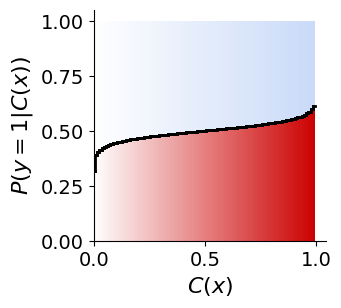

In [14]:
temperature_calibration_curve.plot()

In [15]:
temperature_calibration_curve.get_calibrated_prob(temperature_calibration_curve.x_axis)

array([0.31863754, 0.3882718 , 0.40452118, 0.41437571, 0.42152627,
       0.42717262, 0.43185901, 0.43587917, 0.4394099 , 0.442566  ,
       0.44542624, 0.44804709, 0.45047037, 0.45272798, 0.45484478,
       0.45684055, 0.45873128, 0.4605301 , 0.4622479 , 0.46389384,
       0.46547572, 0.46700019, 0.46847301, 0.46989919, 0.47128313,
       0.47262871, 0.47393935, 0.47521814, 0.47646783, 0.4776909 ,
       0.47888961, 0.480066  , 0.48122196, 0.48235921, 0.48347934,
       0.48458383, 0.48567406, 0.48675129, 0.48781675, 0.48887156,
       0.48991681, 0.49095352, 0.49198266, 0.49300517, 0.49402196,
       0.4950339 , 0.49604183, 0.4970466 , 0.49804902, 0.49904989,
       0.50005   , 0.50105015, 0.50205114, 0.50305375, 0.5040588 ,
       0.5050671 , 0.50607949, 0.50709681, 0.50811994, 0.5091498 ,
       0.51018731, 0.51123347, 0.5122893 , 0.51335588, 0.51443436,
       0.51552595, 0.51663194, 0.51775372, 0.51889276, 0.52005069,
       0.52122923, 0.52243028, 0.5236559 , 0.52490839, 0.52619

In [16]:
intrinsic_selected_dataset.update_calibration_curve(method="mid piecewise linear")
mid_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [17]:
intrinsic_selected_dataset.update_calibration_curve(method="mean piecewise linear")
mean_piecewise_linear_calibration_curve = intrinsic_selected_dataset.calibration_curve

In [18]:
intrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = intrinsic_selected_dataset.calibration_curve

### 1.4 Show plots, including Prevalence estimation

In [19]:
labels = ['pos', 'neg']

estimated prevalence: 0.10090133333333336
[0.         0.         0.         0.         0.00666667 0.04666667
 0.24       0.68666667 0.96666667 1.         1.        ]
estimated prevalence: 0.10144665895777014
[0.         0.         0.         0.         0.00333333 0.02666667
 0.14333333 0.46333333 0.82666667 0.98333333 1.        ]
estimated prevalence: 0.10176428242944649
[0.         0.         0.         0.         0.00363975 0.02934125
 0.15108216 0.46318476 0.81640594 0.98358055 1.        ]
estimated prevalence: 0.11012359670154251
[2.88406890e-04 9.12284911e-04 2.88183738e-03 9.06492084e-03
 2.81396472e-02 8.39516347e-02 2.24849832e-01 4.78658049e-01
 7.43984954e-01 9.01941807e-01 9.66792020e-01]
estimated prevalence: 0.1008848234598805
[0.         0.         0.         0.         0.         0.01333333
 0.16666667 0.38095238 0.875      1.         1.        ]


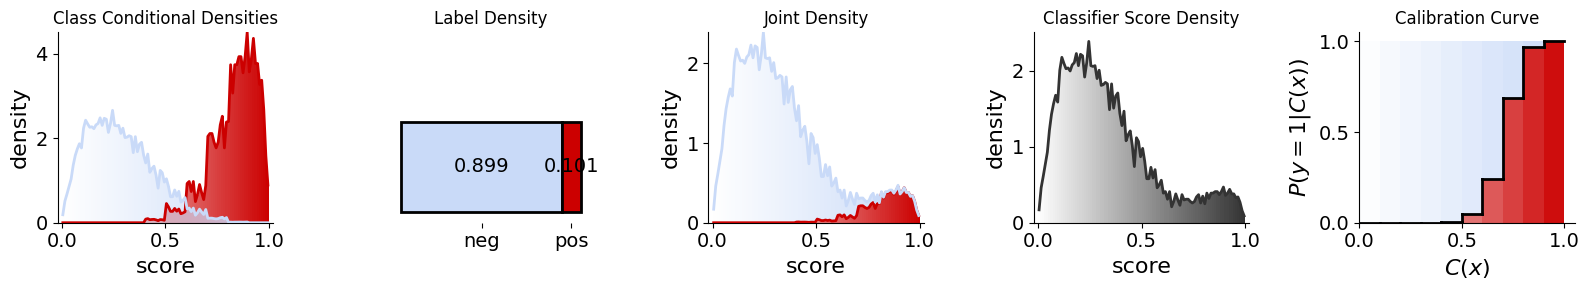

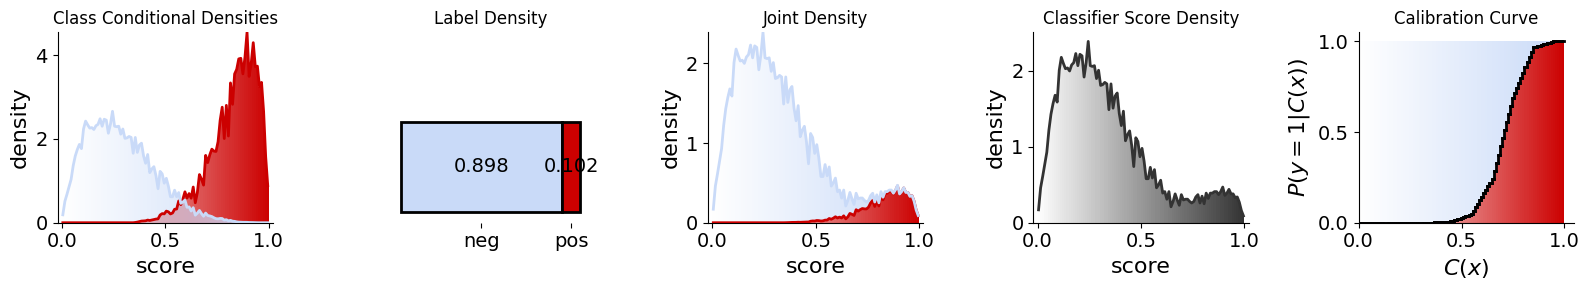

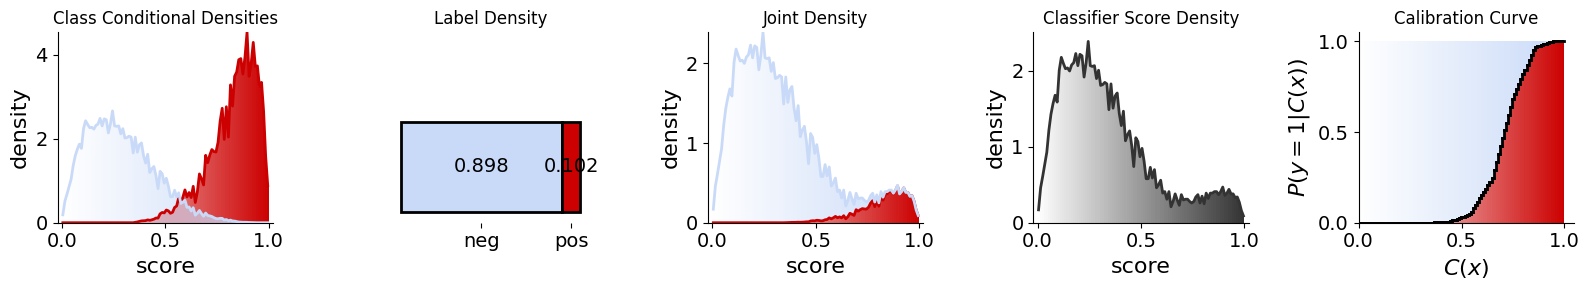

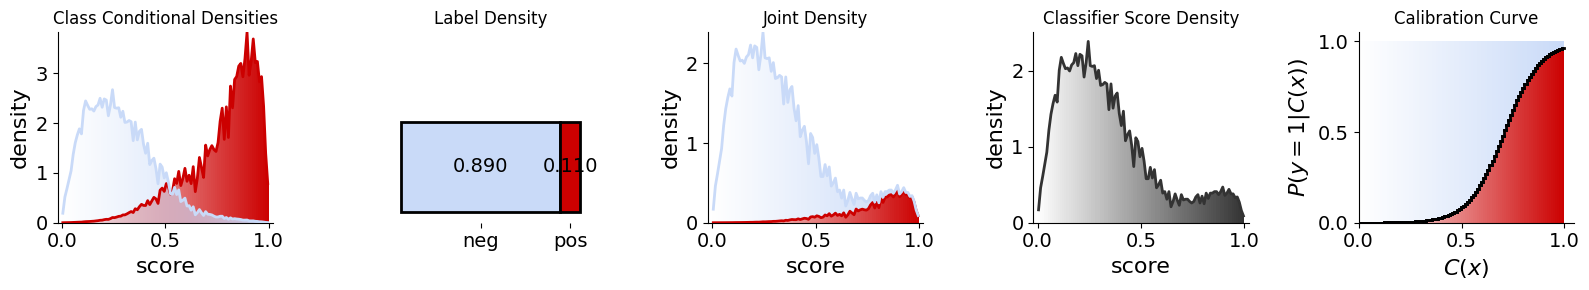

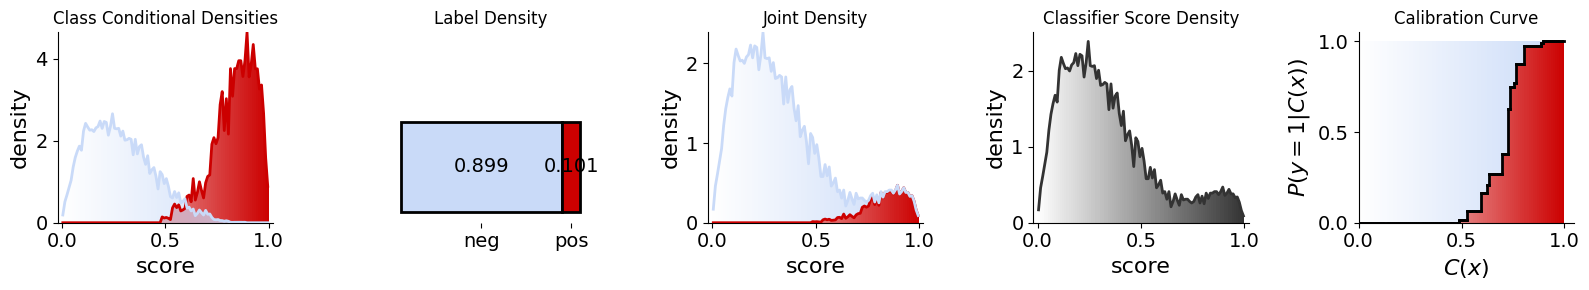

In [20]:
intrinsic_base_dataset.classifier_score_distribution = intrinsic_base_dataset.infer_classifier_score_distribution(num_bin=100)

for cc in [
    binning_calibration_curve,
    mid_piecewise_linear_calibration_curve,
    mean_piecewise_linear_calibration_curve,
    ps_calibration_curve,
    # temperature_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, intrinsic_base_dataset.classifier_score_distribution, cc)
    print('estimated prevalence:', intrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_prob(np.linspace(0, 1, 11)))
    jd.plot_five_distributions()